In [67]:
import numpy
import matplotlib.pyplot as plt
import torch
import torchvision
import deepRD.tools.trajectoryTools as trajectoryTools
from torchvision.transforms import ToTensor
from torch import nn
from torch.utils.data import DataLoader
from sklearn.neighbors import KernelDensity

In [32]:
d1=torch.Tensor(trajectoryTools.loadTrajectory("simMoriZwanzig_", "0001")).unsqueeze(0)
d2=torch.Tensor(trajectoryTools.loadTrajectory("simMoriZwanzig_", "0002")).unsqueeze(0)
d3=torch.Tensor(trajectoryTools.loadTrajectory("simMoriZwanzig_", "0003")).unsqueeze(0)
# time, position (3d), velocity (3d), states (1d), r_aux(3d)
dataset = torch.cat((d1, d2, d3), dim=0)
dataset.shape

torch.Size([3, 10000, 11])

In [94]:
# Number of datasets for training
n_datasets = dataset.shape[0]

# Reform data for input
r_aux = dataset[:, :, -3:]
r_nxt = torch.roll(r_aux, -1, 1)
v = dataset[:, :, 4:7]
r_v = torch.cat((r_aux, v), dim = 2)

# Remove last datapoint for consistency
r_aux = r_aux[:, :-1].flatten(end_dim=1)
r_nxt = r_nxt[:, :-1].flatten(end_dim=1)
v = v[:, :-1].flatten(end_dim=1)
r_v = r_v[:, :-1].flatten(end_dim=1)
# Input: R_n+1 (3), condition: r_n, velocity_n (6)
data = torch.utils.data.TensorDataset(r_nxt, r_v)
r_aux.shape, r_nxt.shape, v.shape, r_v.shape, r_aux[:3], r_nxt[:3], v[:3], r_v[:3]

(torch.Size([29997, 3]),
 torch.Size([29997, 3]),
 torch.Size([29997, 3]),
 torch.Size([29997, 6]),
 tensor([[-0.0051, -0.0105, -0.0113],
         [-0.0117, -0.0048,  0.0076],
         [-0.0024,  0.0068,  0.0205]]),
 tensor([[-0.0117, -0.0048,  0.0076],
         [-0.0024,  0.0068,  0.0205],
         [-0.0042,  0.0036,  0.0133]]),
 tensor([[ 0.1222, -0.1175, -0.4897],
         [ 0.1117, -0.1214, -0.4811],
         [ 0.1104, -0.1136, -0.4596]]),
 tensor([[-0.0051, -0.0105, -0.0113,  0.1222, -0.1175, -0.4897],
         [-0.0117, -0.0048,  0.0076,  0.1117, -0.1214, -0.4811],
         [-0.0024,  0.0068,  0.0205,  0.1104, -0.1136, -0.4596]]))

In [95]:
class VarAutoencoder(nn.Module):

    def __init__(self, latent_dims):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(3+6, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 40),
            nn.ReLU(),
            nn.Linear(40, 20),
            nn.ReLU()
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dims+6, 20),
            nn.ReLU(),
            nn.Linear(20, 40),
            nn.ReLU(),
            nn.Linear(40, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 3)
        )
        self.linear1 = nn.Linear(20, latent_dims)
        self.linear2 = nn.Linear(20, latent_dims)
        self.G = torch.distributions.Normal(0, 1)

    def reparametrize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        return mu + std*self.G.sample(mu.shape)

    def sample(self, label, mean, std, num_samples=1):
        #mean = [0.9080, 0.3038]
        #std = [0.4723, 0.6708]
        x_g = torch.normal(mean[0], std[0], (num_samples,1))
        y_g = torch.normal(mean[1], std[1], (num_samples,1))
        z = torch.cat( (x_g, y_g), dim=1 )
        z_cond = torch.cat((z, label), dim=1)
        return self.decoder(z_cond)

    def forward(self, x, y, return_latent=False):
        x_cond = torch.cat((x,y), dim=1)
        x = self.encoder(x_cond)
        mu = self.linear1(x)
        logvar = self.linear2(x)
        z = self.reparametrize(mu, logvar)
        z_cond = torch.cat((z, y), dim=1)
        output = self.decoder(z_cond)
        if return_latent==True:
            return output, mu, logvar, z
        return output, mu, logvar

In [96]:
loss_1 = nn.MSELoss()
def loss_2(mu, logvar):
    return torch.mean(-0.5 * torch.sum(1 + logvar - mu ** 2 - torch.exp(logvar), dim = 1), dim = 0).sum()

In [108]:
learning_rate = 1e-4
batch_size = 32
beta1 = 10
beta2 = 1e-4
data_loader = DataLoader(data, batch_size=batch_size, shuffle=False)
VAE = VarAutoencoder(2)
optimizer = torch.optim.Adam(VAE.parameters(),
                             lr = learning_rate,
                             weight_decay = 1e-8)

In [118]:
epochs = 20
losses = []
r_norms = None
r_new = None
for epoch in range(epochs):
    VAE.train()
    r_epoch = None
    for (image, label) in data_loader:

        # Feed through the network
        reconstruction, mu, logvar = VAE(image, label)
        # Calculate loss function
        l1 = loss_1(reconstruction, image)
        l2 = loss_2(mu, logvar)
        loss = beta1*l1 + beta2*l2
        losses.append([loss.item(), l1.item(), l2.item()])

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            if r_epoch is None:
                r_epoch = reconstruction
            else:
                r_epoch = torch.cat( (r_epoch, reconstruction), dim=0)
                
            if epoch==epochs-1:
                norms = torch.cat( (torch.norm(image, dim=1).unsqueeze(0), torch.norm(reconstruction, dim=1).unsqueeze(0)) , dim=0)
                if r_norms is None:
                    r_norms = norms
                else:
                    r_norms = torch.cat((r_norms, norms), dim=1)
                    
    if r_new is None:
        r_new = r_epoch.unsqueeze(0)
    else:
        r_new = torch.cat( (r_new, r_epoch.unsqueeze(0)), dim=0) 
                
    print(f'E{epoch+1}:',round(losses[-1][0]*1000,4), round(losses[-1][1]*1000*beta1,4), round(losses[-1][2]*1000*beta2,4))


E1: 0.233 0.146 0.087
E2: 0.2739 0.188 0.086
E3: 0.2455 0.1713 0.0742
E4: 0.2505 0.1766 0.0739
E5: 0.2806 0.1844 0.0962
E6: 0.274 0.1762 0.0978
E7: 0.2829 0.19 0.0929
E8: 0.2815 0.1963 0.0852
E9: 0.3023 0.2271 0.0752
E10: 0.2582 0.195 0.0632
E11: 0.2604 0.192 0.0684
E12: 0.244 0.1862 0.0578
E13: 0.2543 0.2075 0.0468
E14: 0.2621 0.2216 0.0406
E15: 0.205 0.1651 0.0399
E16: 0.2162 0.1778 0.0384
E17: 0.2193 0.1816 0.0377
E18: 0.2267 0.1958 0.031
E19: 0.2257 0.2036 0.0221
E20: 0.1938 0.1699 0.0239


In [119]:
# estimating mean and std of latent space distribution
ind = numpy.random.choice(len(data), len(data))
labels = data[:][1]
with torch.no_grad():
    _, _, _, z = VAE(data[ind][0], data[ind][1], return_latent=True)
    mu = torch.mean(z,0)
    std = torch.std(z,0)

    # generating samples
    generated = VAE.sample(labels, mu, std, num_samples=len(labels))

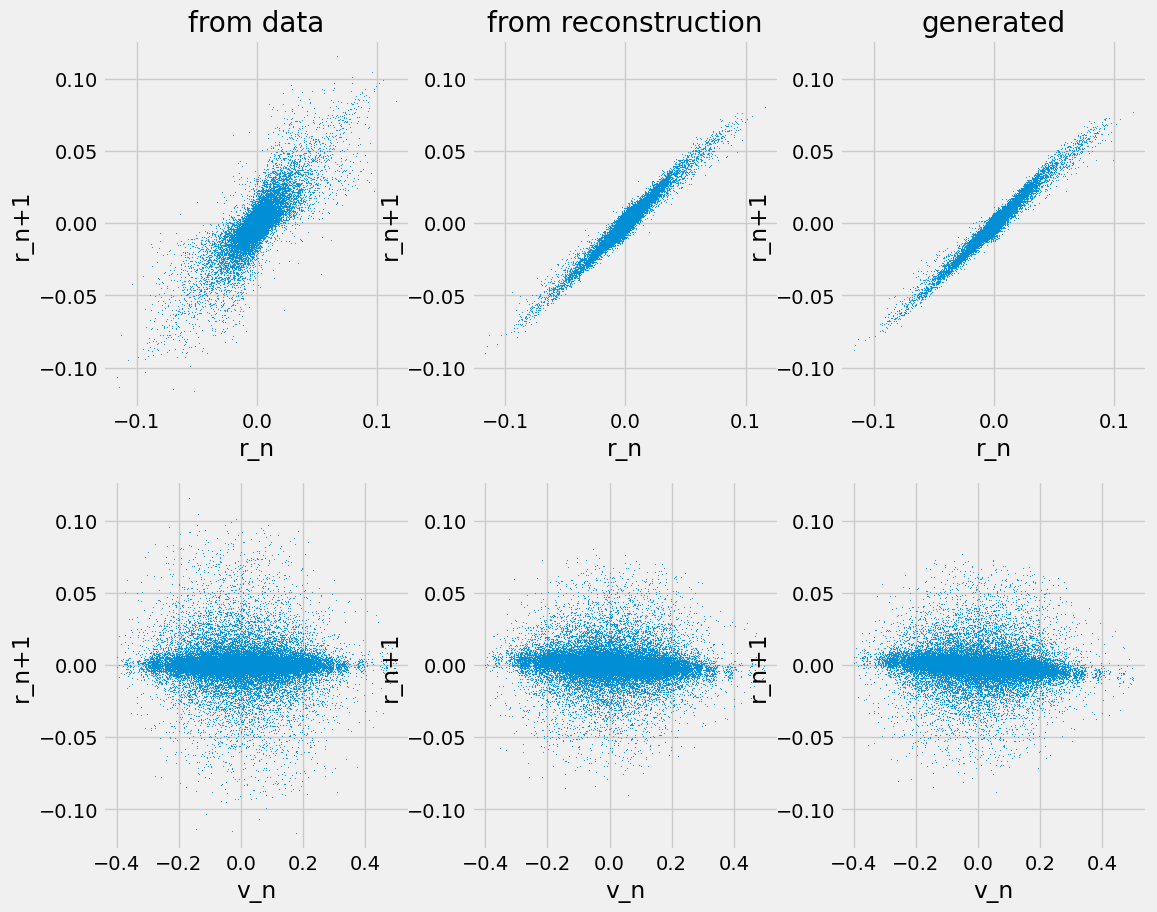

In [120]:
fig = plt.figure(figsize=(12,10))
#print(r_new[-1, :, 0].shape, torch.flatten(r_aux, end_dim=1)[:, 0].shape)

ax1 = fig.add_subplot(2,3,1)
ax1.scatter(r_aux[:, 0], r_nxt[:,0], s=0.1)
ax1.set_xlabel('r_n')
ax1.set_ylabel('r_n+1')
ax1.set_title('from data')

ax2 = fig.add_subplot(2,3,2, sharey=ax1)
ax2.scatter(r_aux[:,0], r_new[-1, :, 0], s=0.1)
#ax2.scatter(torch.flatten(r_aux, end_dim=1)[:,1], r_new[-1, :, 1], s=0.1)
ax2.set_xlabel('r_n')
ax2.set_ylabel('r_n+1')
ax2.set_title('from reconstruction')

ax3 = fig.add_subplot(2,3,3, sharey=ax1)
ax3.scatter(r_aux[:,0], generated[:, 0], s=0.1)
ax3.set_xlabel('r_n')
ax3.set_ylabel('r_n+1')
ax3.set_title('generated')

ax4 = fig.add_subplot(2,3,4)
ax4.scatter(v[:, 0], r_nxt[:,0], s=0.1)
ax4.set_xlabel('v_n')
ax4.set_ylabel('r_n+1')

ax5 = fig.add_subplot(2,3,5, sharey=ax4)
ax5.scatter(v[:, 0], r_new[-1, :, 0], s=0.1)
ax5.set_xlabel('v_n')
ax5.set_ylabel('r_n+1')

ax6 = fig.add_subplot(2,3,6, sharey=ax4)
ax6.scatter(v[:, 0], generated[:,0], s=0.1)
ax6.set_xlabel('v_n')
ax6.set_ylabel('r_n+1')

fig.show()

mean [0.24498284 0.4772375 ] std [0.7859464  0.65764433]


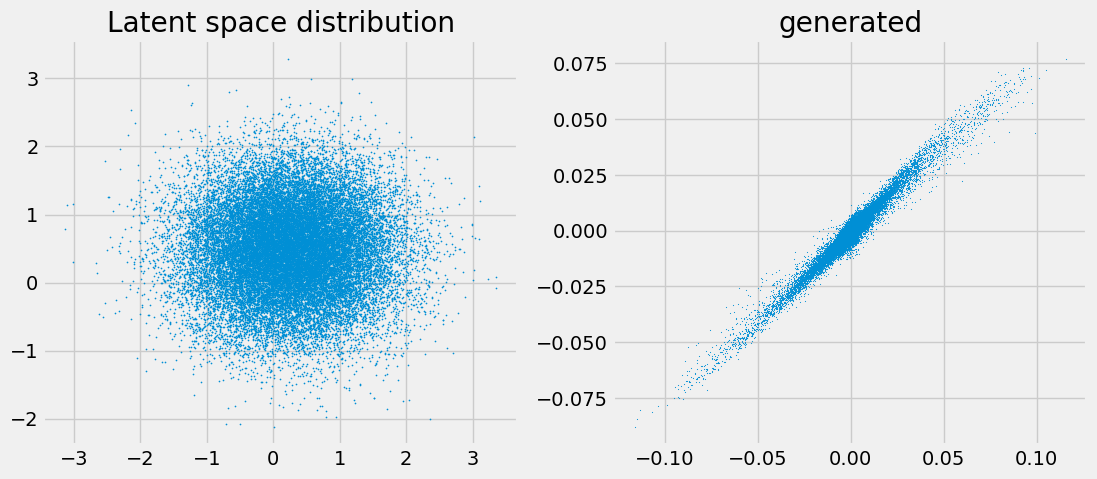

In [121]:
print('mean', mu.numpy(), 'std', std.numpy())
fig = plt.figure(figsize=(12,5))

ax1 = fig.add_subplot(1,2,1)
ax1.scatter(z[:, 0], z[:, 1], s=0.5)
ax1.set_title('Latent space distribution')

ax2 = fig.add_subplot(1,2,2)
ax2.scatter(r_aux[:, 0], generated[:, 0], s=0.1)
ax2.set_title('generated')
fig.show()

In [147]:
r_x = r_aux[:, 0].reshape(-1, 1)
rx_new = r_new[-1, :, 0].reshape(-1, 1)

kde1 = KernelDensity(bandwidth=0.005)
kde1.fit(r_aux)
kde2 = KernelDensity(bandwidth=0.005)
kde2.fit(r_new[-1]);

(1000,)


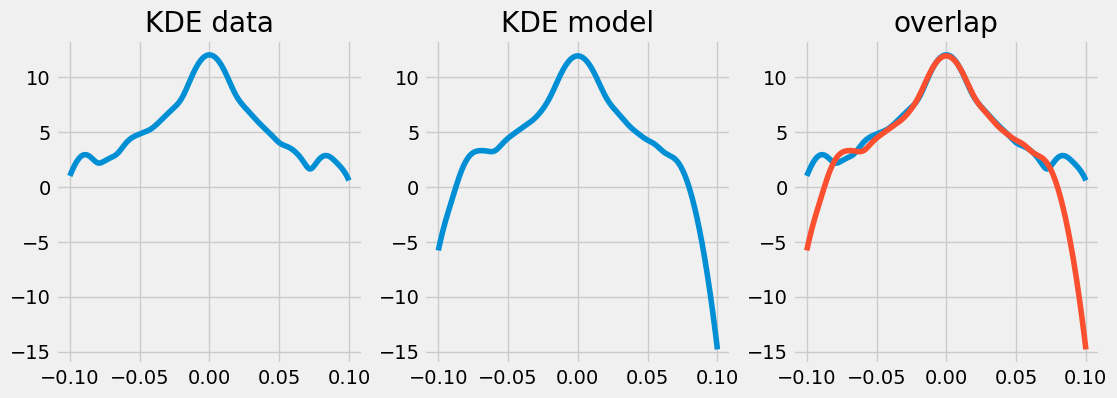

In [171]:
grid = numpy.linspace(-0.1, 0.1, 1000)
z = numpy.full((1000,2), 0)
grid = numpy.concatenate((grid[:, numpy.newaxis],z), axis=1)
pdf_data = kde1.score_samples(grid)
pdf_rec = kde2.score_samples(grid)

print(pdf_data.shape)
fig = plt.figure(figsize=(12,4))

ax1 = fig.add_subplot(1,3,1)
ax1.plot(grid[:,0], pdf_data)
ax1.set_title('KDE data')

ax2 = fig.add_subplot(1,3,2, sharex=ax1, sharey=ax1)
ax2.plot(grid[:,0], pdf_rec)
ax2.set_title('KDE model')

ax3 = fig.add_subplot(1,3,3)
ax3.plot(grid[:,0], pdf_data)
ax3.plot(grid[:,0], pdf_rec)
ax3.set_title('overlap')
fig.show()

In [ ]:
# Save model parameters
torch.save(VAE.state_dict(), 'model_state.pt')